In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
import pandas as pd
import scipy as sy
import sympy as sp
import seaborn as sns
from constants_Acc import *
from function_Acc import *
from pylab import *
from scipy.optimize import curve_fit, minimize_scalar
import scipy.signal as sig
from scipy.interpolate import UnivariateSpline
from symfit import parameters, variables, log, Fit, Model,Poly
import plotly.express as px
import lmfit
import warnings
warnings.filterwarnings('ignore', '.*tight_layout.*',)

## Normal data

In [2]:
Qnet=pd.read_csv('QUOTAS.csv')
Qnet['log_eps'] = Epsilon5100(10 ** (Qnet['log_lbol']), 10 ** (Qnet['log_bh']), 10 ** (Qnet['log_l5100']))
Qnet = Qnet[(Qnet.log_l5100 != 0) & (Qnet.log_l5100 != -99.99) & 
                (Qnet.log_l5100 != -99.999) & (Qnet['log_bh'].notna()) ]
Qn512 = Qnet.reset_index(drop=True)
Qnet['nlMBH'] = 10 ** (Qnet['log_bh'])
Qnetsort = Qnet.sort_values('nlMBH', ascending=True)
Qnet['epsopt_5100']=(Epsilonopt(10**(Qnet['log_lbol']),
                                       10**(Qnet['log_bh']),10**(Qnet['log_l5100']),5100))
Qnet['epsopt_3000']=(Epsilonopt(10**(Qnet['log_lbol']),
                                       10**(Qnet['log_bh']),10**(Qnet['log_l3000']),3000))
Qnet['epsopt_1350']=(Epsilonopt(10**(Qnet['log_lbol']),
                                       10**(Qnet['log_bh']),10**(Qnet['log_l1350']),1350))
Qnet['epsopt_1700']=(Epsilonopt(10**(Qnet['log_lbol']),
                                       10**(Qnet['log_bh']),10**(Qnet['log_l1700']),1700))
Qnet_cols=['name','z','log_bh','log_lbol','log_edd_ratio','log_edd_ratio_err',
 'log_lbol_err','log_l5100','log_l3000','log_l1350','log_l1700','epsopt_5100','epsopt_3000','epsopt_1350','epsopt_1700']
Qnet = Qnet[Qnet_cols]
Qnet=Qnet.drop_duplicates()
Qnet_standard = Qnet[(10**Qnet['log_edd_ratio']<=1) | (1e-2<=10**Qnet['log_edd_ratio'])]
Qnet_standard = Qnet_standard.reset_index(drop=True)
Qnet_standard

,name,z,log_bh,log_lbol,log_edd_ratio,log_edd_ratio_err,log_lbol_err,log_l5100,log_l3000,log_l1350,log_l1700,epsopt_5100,epsopt_3000,epsopt_1350,epsopt_1700
0,SDSS J011521.19+152453.4,3.415000,9.520000,47.570000,-0.140000,0.250000,0.010000,46.61,46.700000,NaN,NaN,0.195632,0.143364,NaN,NaN
1,SDSS J014214.73+002324.3,3.372664,9.690000,47.580000,-0.100000,0.080000,0.020000,46.61,46.860000,NaN,NaN,0.283557,0.119575,NaN,NaN
2,2MASS J01574158-0106297,3.571607,9.955000,47.680000,-0.340000,0.070000,0.010000,46.72,46.910000,NaN,NaN,0.419267,0.217516,NaN,NaN
3,2MASS J02502177-0757499,3.343827,9.465000,47.600000,0.050000,0.050000,NaN,46.63,46.850000,NaN,NaN,0.174659,0.081694,NaN,NaN
4,LBQS 0256-0000,3.374229,9.610000,47.970000,0.160000,0.070000,NaN,47.01,47.100000,NaN,NaN,0.147076,0.107781,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,ULAS J1120+0641,7.100000,9.208819,47.174205,-0.318759,NaN,0.004470,NaN,46.462398,46.623249,NaN,NaN,0.069832,0.040066,NaN
193,VIKING J234833.34-305410.0,6.900000,9.322219,46.684935,-0.744727,NaN,0.130676,NaN,45.973128,NaN,NaN,NaN,0.156498,NaN,NaN
194,VIKING J010953.13-304726.3,6.700000,9.031291,46.741191,-0.619789,NaN,0.053402,NaN,46.029384,46.143015,NaN,NaN,0.080704,0.054506,NaN
195,VIKING J030516.92-315056.0,6.600000,9.028452,46.931915,-0.167491,NaN,0.005201,NaN,46.220108,46.346353,NaN,NaN,0.064135,0.041470,NaN


In [10]:
max_columns = Qnet[['log_l5100', 'log_l3000','log_l1700','log_l1350']].idxmax(axis=1)
eps_min_columns = Qnet[['epsopt_5100', 'epsopt_3000','epsopt_1700','epsopt_1350']].idxmin(axis=1)
Qnet.fillna(np.inf, inplace=True)
# Qnet.fillna(0, inplace=True)
# df_max = Qnet.lookup(Qnet.index, max_columns)
df_eps_min = Qnet.lookup(Qnet.index, eps_min_columns)
# Qnet['L_max_col'] = df_max
Qnet['eps_min_col'] = df_eps_min
Qnet=Qnet.drop_duplicates()

<ipython-input-10-fee6edc70448>:6: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  df_eps_min = Qnet.lookup(Qnet.index, eps_min_columns)


In [11]:
Qnet = Qnet.replace([np.inf], np.nan)
Qnet_nonan=pd.DataFrame({'z':Qnet['z'],'log_bh':Qnet['log_bh'],'epsopt':Qnet['eps_min_col']})
Qnet_nonan=Qnet_nonan[(Qnet_nonan['epsopt'].notna())].reset_index(drop=True)
Qnet_nonan=Qnet_nonan.drop_duplicates()

In [75]:
Qnet_nonan_v2=Qnet_nonan.reset_index(drop=True)
for i in range(len(Qnet_nonan_v2)):
    if Qnet_nonan_v2['epsopt'][i]>1:
        Qnet_nonan_v2=Qnet_nonan_v2.drop([i])
Qnet_nonan_v2=Qnet_nonan_v2.drop_duplicates()
Qnet_nonan_v2

,z,log_bh,epsopt
0,3.415000,9.520000,0.143364
1,3.372664,9.690000,0.119575
2,3.571607,9.955000,0.217516
3,3.343827,9.465000,0.081694
4,3.374229,9.610000,0.107781
...,...,...,...
292,6.901800,9.296665,0.140975
293,7.100000,9.208819,0.040066
294,6.900000,9.322219,0.156498
295,6.700000,9.031291,0.054506


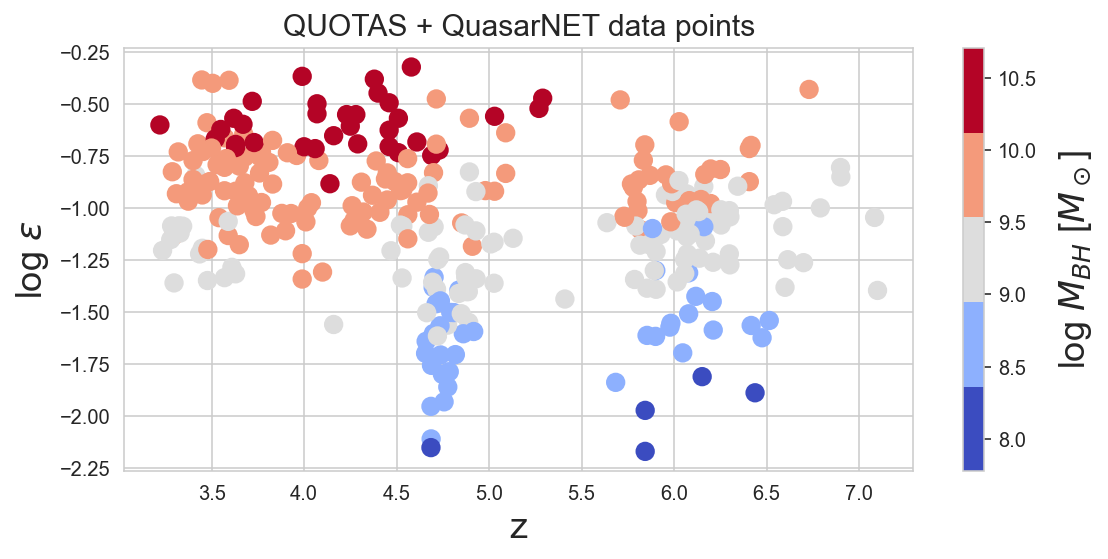

In [97]:
cmap = cm.get_cmap('coolwarm',5)
fig,ax= plt.subplots(figsize=(8, 4))
points = plt.scatter(x=Qnet_nonan_v2.z, y=np.log10(Qnet_nonan_v2.epsopt), c=Qnet_nonan_v2.log_bh,s=75, 
                     cmap=cmap,label='QUOTAS + QUASARNET data points')
cbar=plt.colorbar(points)
cbar.set_label('log $M_{BH}$ [$M_\odot$]', labelpad=10,size=18)
# plt.ylim(0,0.5)
# plt.legend(loc='best')
plt.xlabel('z',size=18)
plt.title('QUOTAS + QuasarNET data points',size=15)
plt.ylabel('log $\epsilon$',size=18)
plt.tight_layout()
sns.set_style("whitegrid")
plt.savefig('log_QN_epsilon_vs_z_MBH_colored.pdf',dpi=600)
plt.show()

## Volume and flux limit correction for data

In [6]:
df = pd.read_csv('flux_vol_eps_bins_2.5.csv')
df_standard=df[(10**df['log_edd_ratio']<=1) | (1e-2<=10**df['log_edd_ratio'])]
df_standard['epsopt_3000']=(Epsilonopt(10**(df_standard['log_lbol']),
                                       10**(df_standard['log_bh']),10**(df_standard['l_3000']),3000))
df_standard['epsopt_1350']=(Epsilonopt(10**(df_standard['log_lbol']),
                                       10**(df_standard['log_bh']),10**(df_standard['l_1350']),1350))
df_standard['epsopt_1700']=(Epsilonopt(10**(df_standard['log_lbol']),
                                       10**(df_standard['log_bh']),10**(df_standard['l_1700']),1700))

In [8]:
df_standard = df_standard.replace([np.inf], np.nan)
df_standard_nonan=pd.DataFrame({'z':df_standard['z'],'log_bh':df_standard['log_bh'],'epsopt':df_standard['eps_min_col']})
df_standard_nonan=df_standard_nonan[(df_standard_nonan['epsopt'].notna())]
df_standard_nonan

,z,log_bh,epsopt
0,5.8440,8.000000,0.010598
1,5.8540,8.954243,0.041062
2,5.8540,8.954243,0.041062
3,5.9030,9.204120,0.061637
4,5.9030,9.204120,0.061637
...,...,...,...
88,6.9018,9.296665,0.140975
89,7.1000,9.208819,0.040066
90,6.9000,9.322219,0.156498
91,6.7000,9.031291,0.054506


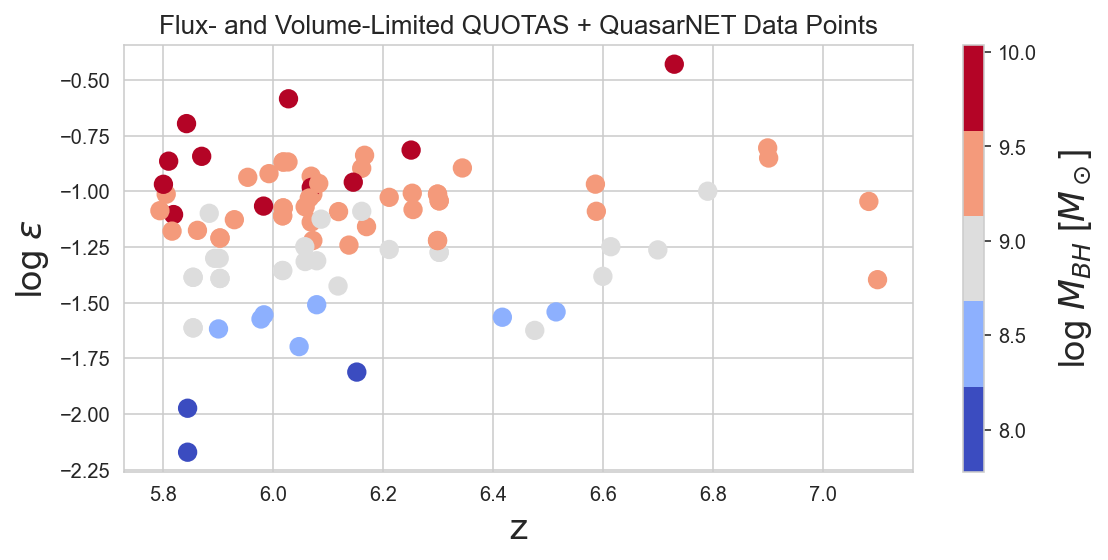

In [113]:
cmap = cm.get_cmap('coolwarm',5)
fig,ax= plt.subplots(figsize=(8, 4))
points = plt.scatter(x=df_standard_nonan.z, y=np.log10(df_standard_nonan.epsopt), c=df_standard_nonan.log_bh,s=75, 
                     cmap=cmap,label=' flux and volume limited QUOTAS + QuasarNET data points')
cbar=plt.colorbar(points)
cbar.set_label('$M_{BH}$', labelpad=10,size=13)
# plt.ylim(0,0.5)
# plt.legend(loc='best')
cbar.set_label('log $M_{BH}$ [$M_\odot$]', labelpad=10,size=18)
plt.xlabel('z',size=18)
plt.title('Flux- and Volume-Limited QUOTAS + QuasarNET Data Points',size=13)
plt.ylabel('log $\epsilon$',size=18)
plt.tight_layout()
plt.savefig('log_QN_vol_epsilon_vs_z_MBH_colored.pdf',dpi=600)
plt.show()

## DL11 data

In [24]:
D11=pd.read_csv('DR11.csv')
D11['epsilon_obsv']=10**(D11['logeps'])
D11['epsopt']=10**(D11['logeps'])
cols11=[4,6,8,11]
D11.drop(D11.columns[cols11],axis=1,inplace=True)
D11=D11.reset_index(drop=True)
Mbh_D11=[];eps_D11=[];Ledd_D11=[];edd_ratio_D11=[];
for i in range(len(D11)):
    Mbh_D11.append(MBHD11(D11['logLoptb'][i],D11['LogMdot'][i]))
for i in range(len(D11)):
    eps_D11.append(EpsilonKopt(10**D11['logLbolb'][i],10**D11['log_bh'][i],10**D11['logLoptb'][i]))
    Ledd_D11.append(Ledd(10**D11['log_bh'][i]))
    edd_ratio_D11.append(eddration(10**D11['log_bh'][i],10**D11['logLbolb'][i]))
D11['Eps_Kopt']=eps_D11
for i in range(len(D11)):
    if D11['Eps_Kopt'][i]>10:
        D11=D11.drop([i])
D11=D11.drop_duplicates()
D11_standard=D11[(10**D11['log_edd_ratio']<=1) | (1e-2<=10**D11['log_edd_ratio'])]
D11_standard

,Object,z,log_bh,log_edd_ratio,logLoptb,LogMdot,logLbolb,logeps,epsilon_obsv,epsopt,Eps_Kopt
0,0003 + 158,0.4505,9.055,-0.358,45.87,0.79,46.92,-0.52,0.301995,0.301995,2.158194
1,0003 + 199,0.0260,7.220,-0.342,43.91,-0.06,45.13,-1.47,0.033884,0.033884,0.739334
2,0007 + 106,0.0893,8.561,-0.972,44.55,-0.42,45.52,-0.72,0.190546,0.190546,3.079148
3,0026 + 129,0.1452,7.833,0.053,44.99,0.80,46.15,-1.30,0.050119,0.050119,0.637104
4,0043 + 039,0.3859,8.952,-0.648,45.47,0.36,45.98,-1.04,0.091201,0.091201,0.816245
...,...,...,...,...,...,...,...,...,...,...,...
75,2130 + 099,0.0631,7.805,-0.367,44.35,0.05,45.52,-1.19,0.064565,0.064565,1.304940
77,2214 + 139,0.0657,8.308,-1.027,44.36,-0.50,45.15,-1.01,0.097724,0.097724,1.520409
78,2251 + 113,0.3255,8.816,-0.363,45.60,0.66,46.13,-1.18,0.066069,0.066069,0.554984
79,2304 + 042,0.0426,8.320,-1.633,43.67,-1.35,44.49,-0.81,0.154882,0.154882,3.751808


In [25]:
D11_standard_article=pd.DataFrame({
    'Object':D11_standard['Object'],'z':D11_standard['z'],'log_bh':D11_standard['log_bh'],'log_lbol':D11_standard['logLbolb'],
    'log_edd_ratio':D11_standard['log_edd_ratio'],'log_lopt':D11_standard['logLoptb'],
    'log_mdot':D11_standard['LogMdot'],'epsobsv':D11_standard['epsilon_obsv']
})
D11_standard_article=D11_standard_article.round(3)
# D11_standard_article.to_csv('D11_standard_article.csv',index=False)

In [34]:
# D11_st_cols=D11_standard.columns.tolist()
# D11_st_cols=['Object','z','log_bh','logLbolb','log_edd_ratio','logLoptb', 'LogMdot','logeps','epsilon_obsv','Eps_Kopt','epsopt']
# D11_standard=D11_standard[D11_st_cols]
# D11_standard

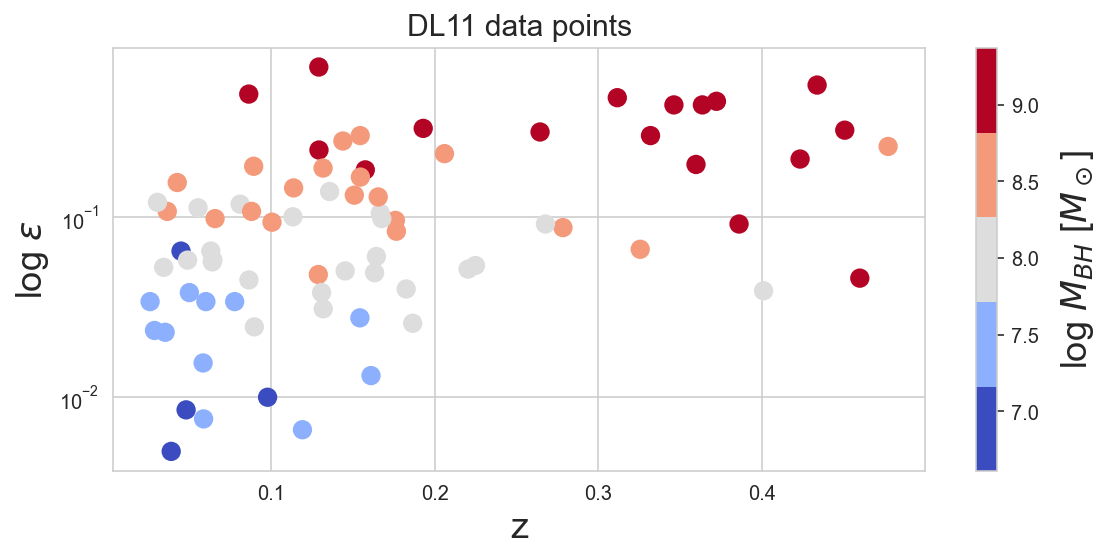

In [99]:
from pylab import *
cmap = cm.get_cmap('coolwarm',5)
fig,ax= plt.subplots(figsize=(8, 4))
points = plt.scatter(x=D11_standard.z, y=D11_standard.epsilon_obsv, c=D11_standard.log_bh,s=75, 
                     cmap=cmap,label='$DL_{11}$')
cbar=plt.colorbar(points)
cbar.set_label('log $M_{BH}$ [$M_\odot$]', labelpad=10,size=18)
# plt.ylim(0,0.5)
# plt.legend(loc='best')
plt.xlabel('z',size=18)
plt.title('DL11 data points',size=15)
plt.ylabel('log $\epsilon$',size=18)
plt.tight_layout()
sns.set_style("whitegrid")
plt.savefig('log_D11_epsilon_vs_z_MBH_colored.pdf',dpi=600)
plt.yscale('log')
plt.show()

-----

## Mixing DL11 and QN

In [79]:
df_11_qn=pd.concat([Qnet_nonan_v2,D11_standard],ignore_index=False)
df_11_qn_cols=df_11_qn.columns.tolist()
df_11_qn_cols=['z','epsopt','log_bh']
df_11_qn=df_11_qn[df_11_qn_cols]
df_11_qn=df_11_qn.dropna()
df_11_qn=df_11_qn.reset_index(drop=True)
df_11_qn.drop_duplicates()

,z,epsopt,log_bh
0,3.415000,0.143364,9.520
1,3.372664,0.119575,9.690
2,3.571607,0.217516,9.955
3,3.343827,0.081694,9.465
4,3.374229,0.107781,9.610
...,...,...,...
368,0.063100,0.064565,7.805
369,0.065700,0.097724,8.308
370,0.325500,0.066069,8.816
371,0.042600,0.154882,8.320


y_cal = -0.01875 * x**2 + 0.10418 * x +  -1.10393 
The peaks of D11 + QN =[2.778]


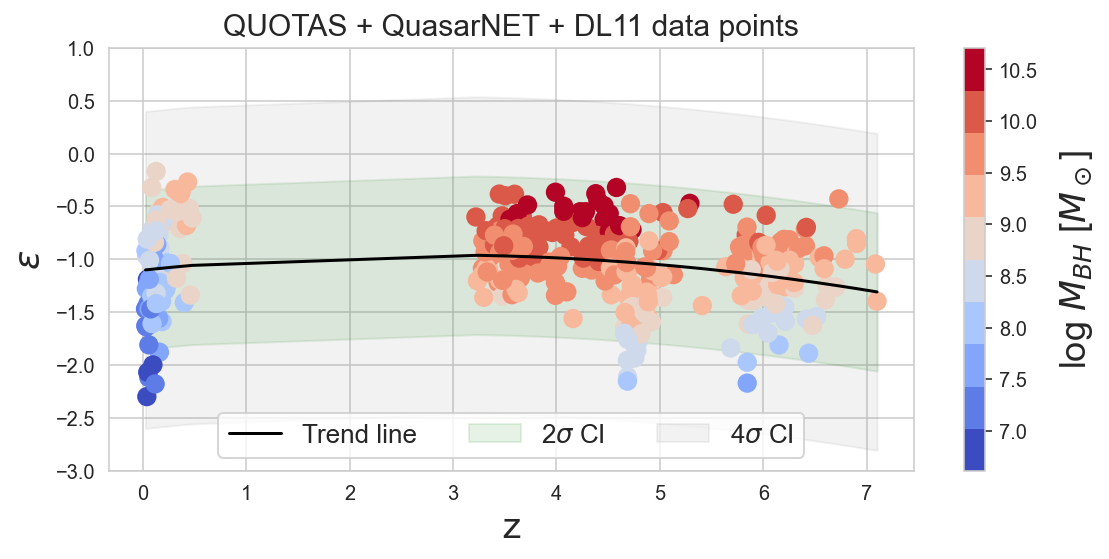

In [106]:
from pylab import *
cmap = cm.get_cmap('coolwarm',10)
fig,ax= plt.subplots(figsize=(8, 4))

df_11_qn_sort=df_11_qn.sort_values('z')
x_11qn = df_11_qn_sort['z'].values
y_11qn = np.log10(df_11_qn_sort['epsopt']).values

def obj(x, a, b,c):
    return a * x**2 + b*x+c

guess = [min(y_11qn), min(y_11qn), min(y_11qn)]
parameters_11qn, _ = curve_fit(obj, x_11qn, y_11qn)

fit_D_11qn = parameters_11qn[0]
fit_E_11qn = parameters_11qn[1]
fit_F_11qn = parameters_11qn[2]

fit_obj_11qn = obj(x_11qn, fit_D_11qn, fit_E_11qn,fit_F_11qn)

residuals_11qn = y_11qn - fit_obj_11qn
sigma2_11qn = 2 * np.std(residuals_11qn)
sigma4_11qn= 4 * np.std(residuals_11qn)


print('y_cal = %.5f * x**2 + %.5f * x +  %.5f ' % (fit_D_11qn, fit_E_11qn,fit_F_11qn))
plt.plot(x_11qn, fit_obj_11qn, 'black', label='Trend line')
plt.fill_between(x_11qn, fit_obj_11qn - sigma2_11qn, fit_obj_11qn + sigma2_11qn,color='g', alpha=0.1,label='2$\sigma$ CI')
plt.fill_between(x_11qn, fit_obj_11qn - sigma4_11qn, fit_obj_11qn + sigma4_11qn,color='grey', alpha=0.1,label='4$\sigma$ CI')
# plt.axhspan(0.0, -0.5, alpha=0.1,hatch='/',color='r',xmin=0.044,xmax=1-0.045)
def fit_Qnet_11(x):
    return fit_D_11qn * x**2 + fit_E_11qn * x +  fit_F_11qn
fit_Qnet_dict[0] = fit_Qnet_11
x_q=np.arange(0,8,0.001)
peaks, _ = sig.find_peaks(fit_Qnet_dict[0](x_q))
print("The peaks of D11 + QN ={}".format(x_q[peaks]))
points = plt.scatter(x=df_11_qn.z, y=np.log10(df_11_qn.epsopt), c=df_11_qn.log_bh,s=75, 
                     cmap=cmap)
cbar=plt.colorbar(points)
cbar.set_label('log $M_{BH}$ [$M_\odot$]', labelpad=10,size=18)
plt.ylim(-3,1)
# plt.xlim(-0.1,7+0.1)
plt.legend(ncol=3,loc='lower center',fontsize=13)
plt.xlabel('z',size=18)
plt.title('QUOTAS + QuasarNET + DL11 data points',size=15)
plt.ylabel('$\epsilon$',size=18)
plt.tight_layout()
sns.set_style("whitegrid")
plt.savefig('log_greensigma_epsilon_vs_z_11_qn_novol_fit.pdf',dpi=600)
plt.show()

---

## Mixing DL11 and Vol and fluxed

In [32]:
df_11_vol=pd.concat([df_standard_nonan,D11_standard],ignore_index=False)
df_11_vol_cols=df_11_vol.columns.tolist()
df_11_vol_cols=['z','epsopt','log_bh']
df_11_vol=df_11_vol[df_11_vol_cols]
df_11_vol=df_11_vol.dropna()
df_11_vol=df_11_vol.reset_index(drop=True)
df_11_vol

,z,epsopt,log_bh
0,5.8440,0.010598,8.000000
1,5.8540,0.041062,8.954243
2,5.8540,0.041062,8.954243
3,5.9030,0.061637,9.204120
4,5.9030,0.061637,9.204120
...,...,...,...
162,0.0631,0.064565,7.805000
163,0.0657,0.097724,8.308000
164,0.3255,0.066069,8.816000
165,0.0426,0.154882,8.320000


The peaks of D11 + QN =[2.577]
y_cal = -0.00968 * x**2 + 0.04989 * x +  -1.10613 


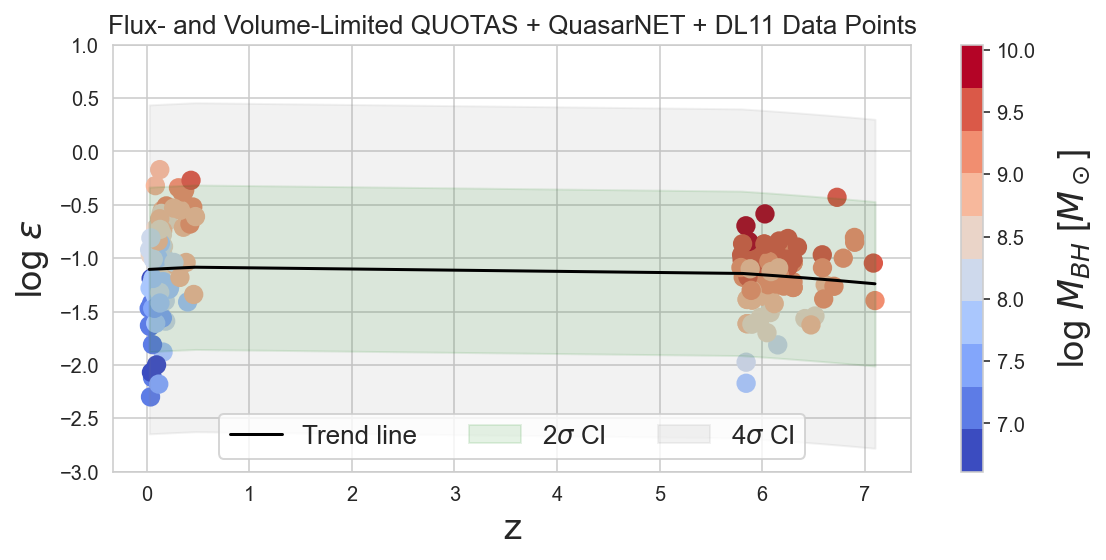

In [114]:
cmap = cm.get_cmap('coolwarm',10)
fig,ax= plt.subplots(figsize=(8, 4))
fit_Qnet_dict = {}
points = plt.scatter(x=df_11_vol.z, y=np.log10(df_11_vol.epsopt), c=df_11_vol.log_bh,s=75, 
                     cmap=cmap)
df_11_vol_sort=df_11_vol.sort_values('z')
x_flvl = df_11_vol_sort['z'].values
y_flvl = np.log10(df_11_vol_sort['epsopt']).values

def obj(x, a, b,c):
    return a * x**2 + b*x+c

guess = [min(y_flvl), min(y_flvl), min(y_flvl)]
parameters_flvl, _ = curve_fit(obj, x_flvl, y_flvl)

fit_D_flvl = parameters_flvl[0]
fit_E_flvl = parameters_flvl[1]
fit_F_flvl = parameters_flvl[2]

fit_obj_flvl = obj(x_flvl, fit_D_flvl, fit_E_flvl,fit_F_flvl)
def fit_Qnet(x):
    return fit_D_flvl * x**2 + fit_E_flvl * x +  fit_F_flvl
fit_Qnet_dict[0] = fit_Qnet
x_q=np.arange(0,8,0.001)
peaks, _ = sig.find_peaks(fit_Qnet_dict[0](x_q))
print("The peaks of D11 + QN ={}".format(x_q[peaks]))
print('y_cal = %.5f * x**2 + %.5f * x +  %.5f ' % (fit_D_flvl, fit_E_flvl,fit_F_flvl))


residuals_flvl = y_flvl - fit_obj_flvl
sigma2_flvl = 2 * np.std(residuals_flvl)
sigma4_flvl= 4 * np.std(residuals_flvl)
plt.fill_between(x_flvl, fit_obj_flvl - sigma2_flvl, fit_obj_flvl + sigma2_flvl,color='g', alpha=0.1,label='2$\sigma$ CI')
plt.fill_between(x_flvl, fit_obj_flvl - sigma4_flvl, fit_obj_flvl + sigma4_flvl,color='grey', alpha=0.1,label='4$\sigma$ CI')
# plt.axhspan(0.0, -0.5, alpha=0.1,hatch='/',color='r',xmin=0.044,xmax=1-0.045)

plt.plot(x_flvl, fit_obj_flvl, 'black',label='Trend line')
cbar=plt.colorbar(points)
cbar.set_label('log $M_{BH}$ [$M_\odot$]', labelpad=10,size=18)
plt.xlabel('z',size=18)
plt.ylim(-3,1)
plt.title('Flux- and Volume-Limited QUOTAS + QuasarNET + DL11 Data Points',size=13)
plt.ylabel('log $\epsilon$',size=18)
plt.tight_layout()
# plt.yscale('log')
plt.legend(ncol=3,loc='lower center',fontsize=13)
plt.savefig('log_vol_epsilon_vs_z_11_qn_novol_fit.pdf',dpi=600)
plt.show()